In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
#import multiprocessing
import itertools
from tqdm import tqdm
from scipy.interpolate import interp1d

from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import plot


In [2]:
### Global variables ###
indir = './outputs/tracks-slurm/'
outdir = './outputs/tracks-plt/time-meanSpd/'
os.makedirs(outdir, exist_ok=True)

In [3]:
def main(idx):
    idx_str = '{0:02}'.format(idx)
    
    df_meta = pd.read_pickle(indir + idx_str + '_meta.pkl')
    upperLaneMarkings = np.fromstring(df_meta['upperLaneMarkings'][0], sep=";")
    lowerLaneMarkings = np.fromstring(df_meta['lowerLaneMarkings'][0], sep=";")
    upperLaneId = list(range(2, len(upperLaneMarkings)+1))
    lowerLaneId = list(range(len(upperLaneMarkings)+2, len(upperLaneMarkings)+len(lowerLaneMarkings)+1))
    
    df = pd.read_pickle(indir + idx_str + '_data.pkl')
    lsTime = np.arange(0, (int(max(df['finalFrame']))-1)/df_meta['frameRate'][0], 10)
    lsPos = np.arange(0, max(max(l) for l in df['x']), 10)

    tdMat1, tdMat2 = pd.DataFrame(), pd.DataFrame()
    for i in range(len(lsTime)-1):
        tdMat1 = pd.concat([tdMat1, pd.DataFrame({f'T{i}': [[] for _ in range(len(lsPos)-1)]})], axis=1)
        tdMat2 = pd.concat([tdMat2, pd.DataFrame({f'T{i}': [[] for _ in range(len(lsPos)-1)]})], axis=1)

    for i in tqdm(range(len(df))):
        arrTraj = np.array([
            (df['frame'][i]-1)/df_meta['frameRate'][0], # time
            df['x'][i],                                 # x
        ]).T

        ftp = interp1d(arrTraj[:,0], arrTraj[:,1], kind='linear')
        fpt = interp1d(arrTraj[:,1], arrTraj[:,0], kind='linear')

        tmin, tmax, pmin, pmax = min(arrTraj[:,0]), max(arrTraj[:,0]), min(arrTraj[:,1]), max(arrTraj[:,1])

        ipmin = np.digitize(pmin, lsPos, right=False)
        ipmax = np.digitize(pmax, lsPos, right=True)

        itmin = np.digitize(tmin, lsTime, right=False)
        itmax = np.digitize(tmax, lsTime, right=True)

        gridp = np.array([
            fpt(lsPos[ipmin:ipmax]),
            lsPos[ipmin:ipmax],]).T
        gridt = np.array([
            lsTime[itmin:itmax],
            ftp(lsTime[itmin:itmax]),]).T
        arr = np.vstack((arrTraj[0,:], arrTraj[-1,:], gridp, gridt))

        arr = arr[np.where(
            (arr[:,0]>=lsTime[0]) & (arr[:,0]<=lsTime[-1]) &
            (arr[:,1]>=lsPos[0]) & (arr[:,1]<=lsPos[-1])
            )]
        
        unique_keys, indices = np.unique(arr[:,0], return_index=True)
        arr = arr[indices]
        unique_keys, indices = np.unique(arr[:,1], return_index=True)
        arr = arr[indices]

        arrInterp = arr[arr[:, 0].argsort()]

        for k in range(1, len(arrInterp)):
            cx = (arrInterp[k-1, 0] + arrInterp[k, 0]) / 2
            cy = (arrInterp[k-1, 1] + arrInterp[k, 1]) / 2
            icx = np.digitize(cx, lsTime)-1
            icy = np.digitize(cy, lsPos)-1

            dx = np.abs(arrInterp[k, 0] - arrInterp[k-1, 0])
            dy = np.abs(arrInterp[k, 1] - arrInterp[k-1, 1])

            if df['drivingDirection'][i] == 1:
                tdMat1[f'T{icx}'][icy].append(np.array([dx, dy]))
            else:
                tdMat2[f'T{icx}'][icy].append(np.array([dx, dy]))

    tdMat1.to_csv(outdir + idx_str + '_tdMat1.csv', index=False)
    tdMat2.to_csv(outdir + idx_str + '_tdMat2.csv', index=False)

    def calMeanSpd(lsPos, lsTime, tdMat):
        arrMeanSpd = np.zeros((len(lsPos)-1, len(lsTime)-1))
        for i, j in itertools.product(range(len(lsPos)-1), range(len(lsTime)-1)):
            if len(tdMat[f'T{j}'][i]):
                sumTD = np.sum(np.array(tdMat[f'T{j}'][i]), axis=0)
                sumTime, sumDistance = sumTD[0], sumTD[1]
                arrMeanSpd[i, j] = sumDistance / sumTime
            else:
                arrMeanSpd[i, j] = -1
        return arrMeanSpd

    arrMeanSpd1 = calMeanSpd(lsPos, lsTime, tdMat1)
    arrMeanSpd2 = calMeanSpd(lsPos, lsTime, tdMat2)
    
    np.savetxt(outdir + idx_str + '_arrMeanSpd1.csv', arrMeanSpd1, delimiter=",")
    np.savetxt(outdir + idx_str + '_arrMeanSpd2.csv', arrMeanSpd2, delimiter=",")

    fig, axes = plt.subplots(figsize=(18, 12), nrows=2, ncols=1)
    vmin, vmax = df['minXVelocity'].min(), df['maxXVelocity'].max()
    cmap = matplotlib.cm.get_cmap("rainbow").copy()
    cmap.set_bad(color='white')
    masked_arr1 = np.ma.masked_where(arrMeanSpd1 == -1, arrMeanSpd1)
    masked_arr2 = np.ma.masked_where(arrMeanSpd2 == -1, arrMeanSpd2)

    im1 = axes[0].imshow(masked_arr1, aspect='equal', vmin=vmin, vmax=vmax, cmap=cmap, origin='lower')
    axes[0].set_ylabel(r'Position (m) - Direct 1 (to 0m)')
    axes[0].set_xticks(np.arange(-0.5, len(lsTime), 5), np.arange(0, 10*len(lsTime), 50))
    axes[0].set_yticks(np.arange(4.5, len(lsPos), 5), np.arange(50, 10*len(lsPos), 50))
    axes[0].grid()
    
    im2 = axes[1].imshow(masked_arr2, aspect='equal', vmin=vmin, vmax=vmax,  cmap=cmap, origin='lower')
    axes[1].set_ylabel(r'Position (m) - Direct 2 (from 0m)')
    axes[1].set_xlabel(r'Time (s)')
    axes[1].set_xticks(np.arange(-0.5, len(lsTime), 5), np.arange(0, 10*len(lsTime), 50))
    axes[1].set_yticks(np.arange(4.5, len(lsPos), 5), np.arange(50, 10*len(lsPos), 50))
    axes[1].grid()
    
    # fig.colorbar(im2, orientation="horizontal", pad=0.1)
    cbar = fig.colorbar(im2, ax=axes.ravel().tolist(), orientation='vertical', shrink=0.8, aspect=20)
    cbar.set_label('Edie\'s mean speed (m/s)')
    plt.savefig(outdir + idx_str + '_arrMeanSpd.pdf', dpi=300, bbox_inches='tight')
    
    return fig

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1467/1467 [00:02<00:00, 719.58it/s]


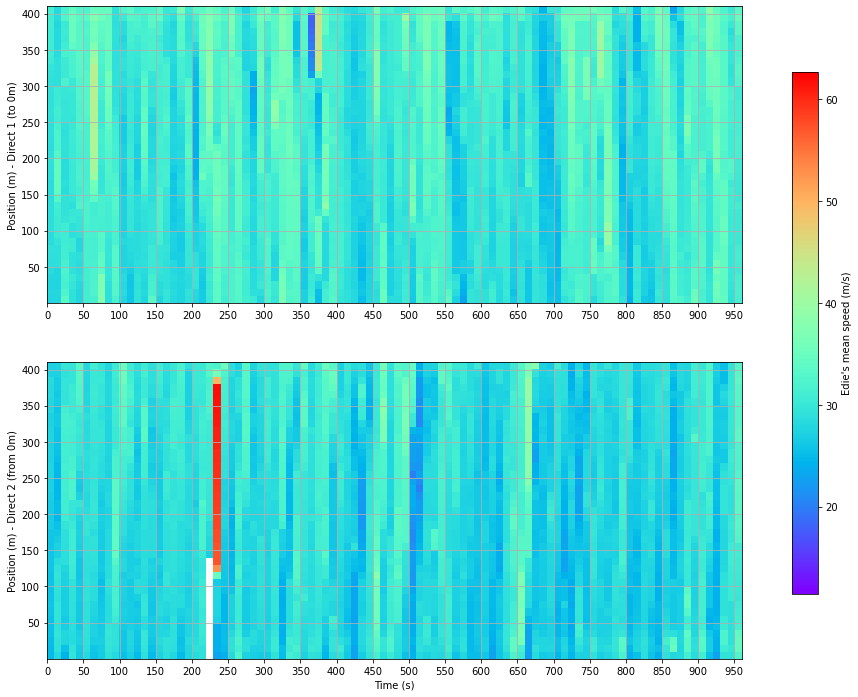

In [4]:
fig = main(60)